In [1]:
import sys
sys.path.append("./scripts/")
import math
import numpy as np
from gridmap import*
from robot import*
from astar import*
from dstar import*
from dstarlite import*
from bug import*
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [2]:
class PathFollower(Robot):
    def __init__(
        self, world, pp_algorithm, color="black",
        noise_per_meter=5, noise_std=np.pi/60, bias_rate_stds=(0.0, 0.0)
    ):
        super().__init__(
            None, agent=None, sensor=None, color=color, 
            noise_per_meter=noise_per_meter, noise_std=noise_std, bias_rate_stds=bias_rate_stds,
            expected_stuck_time=1e100, expected_escape_time = 1e-100,
            expected_kidnap_time=1e1000, kidnap_range_x = (0.0,0.0), kidnap_range_y = (0.0,0.0)
        )
        self.world = world
        if np.any(self.world.start_index == None) or np.any(self.world.goal_index == None):
            theta = 0.0
        else:
            d_pose = self.world.goal_index - self.world.start_index
            theta = np.arctan2(d_pose[1], d_pose[0])
        self.pose = np.append(self.world.start_index * self.world.grid_step + self.world.grid_step / 2, theta)
        self.poses = [self.pose]
        self.r = 0.02
        self.pp_algorithm = pp_algorithm
        self.followIndex = self.world.start_index
        self.nu = 0.0
        self.nu_acc = 0.2
        self.nu_min = 0.0
        self.nu_max = 0.4
        self.nu_delta = 0.01
        self.omega = 0.0
        self.omega_acc = 180*np.pi/180
        self.omega_min = -320*np.pi / 180
        self.omega_max = 320*np.pi / 180
        self.omega_delta = 10*np.pi / 180
        self.time_interval = self.world.time_interval
        self.way_point = self.indexToPose(self.world.goal_index)
        
    def draw(self, ax, elems):
        self.drawRobot(self.pose, ax, elems)
        self.drawTakenPath(self.poses, ax, elems, linewidth=1.0, color="red")
        
        if self.isRobotInGoal(self.pose):
            return
        
        next_index = self.poseToIndex(self.pose)
        if hasattr(self.pp_algorithm, "checkNewObstacle"):
            self.pp_algorithm.checkNewObstacle(next_index)
            self.pp_algorithm.drawNewObstacles(ax, elems)# if(not self.pp_algorithm.drawMetricMap_flag) else None
        
        while np.linalg.norm(self.poseToIndex(self.pose) - next_index) < 1.4:
            try:
                next_index = self.pp_algorithm.next(next_index)
            except PathNotCalculatedError:
                self.pp_algorithm.run()
                next_index = self.pp_algorithm.next(self.world.start_index)
            if np.any(next_index == None):
                next_index = self.followIndex
            if self.world.isGoal(next_index):
                break
        self.way_point = next_index
        
        control_inputs = self.controlInputCandidate()
        path_candidates = self.pathCandidate(control_inputs)
        nu, omega = self.selectPath(path_candidates)
        
        self.followIndex = next_index
        self.world.drawGrid(self.followIndex, "blue", 0.5, ax, elems=elems)
        self.nu, self.omega = nu, omega
        
        self.pose = self.state_transition(self.nu, self.omega, self.world.time_interval, self.pose)
        self.poses.append(self.pose)
        
    def controlInputCandidate(self):
        controlInput = []
        for omega in np.arange(self.omega_min, self.omega_max, self.omega_delta):
            controlInput.append([self.nu_max, omega])
            controlInput.append([0, omega])
            #controlInput.append([0.0, omega])
            #for nu in np.arange(self.nu-self.nu_acc, self.nu+self.nu_acc+1e-5, self.nu_delta):
            #    if (nu < self.nu_max and nu > self.nu_min) and (omega < self.omega_max and omega > self.omega_min):
            #        controlInput.append([nu, omega])
        return controlInput
    
    def pathCandidate(self, control_inputs):
        candidate_path = []
        for control_input in control_inputs:
            xs, ys, thetas = self.pose
            nu, omega = control_input
            path = [[xs, ys, thetas, 0.0, 0.0]]
            flag=0
            for i in range(3):
                xf, yf, thetaf = self.state_transition(nu, omega, self.world.time_interval, np.array([xs, ys, thetas]))
                if self.isRobotInObstacle([xf, yf, thetaf]):
                    flag=1
                    break
                path.append([xf, yf, thetaf, nu, omega])
                xs, ys, thetas = xf, yf, thetaf
            candidate_path.append(path) if flag==0 else None
        return candidate_path
    
    def selectPath(self, path_candidates, speed=10.0, goalH=0.0, goalD=1.0, obs=0.0):
        cost = float('inf')
        c_goalH_c = float('inf')
        c_goalD_c = float('inf')
        select_nu, select_omega = 0.0, 0.0
        for path in path_candidates:
            x, y, theta, nu, omega = path[-1]
            c_speed = self.costSpeed(nu)
            c_goalH = self.costGoalHeading([x, y, theta])
            c_goalD = self.costGoalDistance([x, y, theta])
            c_obs = self.costObstacle([x, y, theta]) if obs != 0.0 else 0.0
            c = c_speed*c_speed + goalH*c_goalH + goalD*c_goalD
            if(c < cost):
                cost = c
                select_nu, select_omega = nu, omega
        return select_nu, select_omega
    
    def costObstacle(self, pose):
        index = self.poseToIndex(pose)
        theta = pose[2]
        cost = 0.0
        for i in range(-1, 3):
            for j in range(-1, 3):
                if not self.isInRange(np.arctan2(j, i), theta-45, theta+45):
                    continue
                sensing_index = index + np.array([i, j])
                if self.world.isOutOfBounds(sensing_index):
                    cost += 1.0
                if self.world.isObstacle(sensing_index):
                    cost += 1.0 / (np.linalg.norm(pose[0:2] - self.indexToPose(sensing_index)[0:2])+1e-5)
        return cost
    
    def costSpeed(self, nu):
        return self.nu_max - nu
    
    def costGoalDistance(self, pose):
        cost = np.linalg.norm(pose[0:2] - self.indexToPose(self.way_point)[0:2])
        return cost
    
    def costGoalHeading(self, pose):
        theta = np.arctan2(self.indexToPose(self.way_point)[0:2][1] - pose[0:2][1], self.indexToPose(self.way_point)[0:2][0] - pose[0:2][0])
        d_theta = abs(pose[2] - theta)
        return d_theta

In [21]:
class BugFollower(PathFollower):
    def __init__(
        self, world, color="black",
        noise_per_meter=5, noise_std=np.pi/60, bias_rate_stds=(0.0, 0.0)
    ):
        super().__init__(
            world, BUG(world), color="black",
            noise_per_meter=5, noise_std=np.pi/60, bias_rate_stds=(0.0, 0.0)
        )
        
    def draw(self, ax, elems):
        self.drawRobot(self.pose, ax, elems)
        self.drawTakenPath(self.poses, ax, elems, linewidth=1.0, color="red")
        
        if self.isRobotInGoal(self.pose):
            return
        
        if(len(self.pp_algorithm.m_line) == 0):
            self.pp_algorithm.initialize()
        
        currentIndex = self.poseToIndex(self.pose)
        self.way_point = self.pp_algorithm.next(currentIndex)
        
        d_theta = np.arctan2(self.way_point[1] - currentIndex[1], self.way_point[0] - currentIndex[0]) - self.pose[2]
        while d_theta > np.pi:
            d_theta -= 2*np.pi
        while d_theta < -np.pi:
            d_theta += 2*np.pi
        if d_theta < -np.pi/3:
            nu, omega = 0.0, -320*np.pi/180
        elif d_theta > np.pi/3:
            nu, omega = 0.0, 320*np.pi/180
        elif d_theta < -np.pi/6:
            nu, omega = 0.1, -320*np.pi / 180
        elif d_theta > np.pi/6:
            nu, omega = 0.1, 320*np.pi / 180
        else:
            control_inputs = self.controlInputCandidate()
            path_candidates = self.pathCandidate(control_inputs)
            nu, omega = self.selectPath(path_candidates, speed=10.0, goalH=0.00, goalD=1.0)
        
        self.world.drawGrid(self.way_point, "blue", 0.5, ax, elems=elems)
        self.nu, self.omega = nu, omega
        self.pose = self.state_transition(self.nu, self.omega, self.world.time_interval, self.pose)
        self.poses.append(self.pose)
        
    def pathCandidate(self, control_inputs):
        candidate_path = []
        for control_input in control_inputs:
            xs, ys, thetas = self.pose
            nu, omega = control_input
            path = [[xs, ys, thetas, 0.0, 0.0]]
            flag=0
            for i in range(1):
                xf, yf, thetaf = self.state_transition(nu, omega, self.world.time_interval, np.array([xs, ys, thetas]))
                if self.isRobotInObstacle([xf, yf, thetaf]):
                    flag=1
                    break
                path.append([xf, yf, thetaf, nu, omega])
                xs, ys, thetas = xf, yf, thetaf
            candidate_path.append(path) if flag==0 else None
        return candidate_path

[ 9 97] [97 26]


<IPython.core.display.Javascript object>


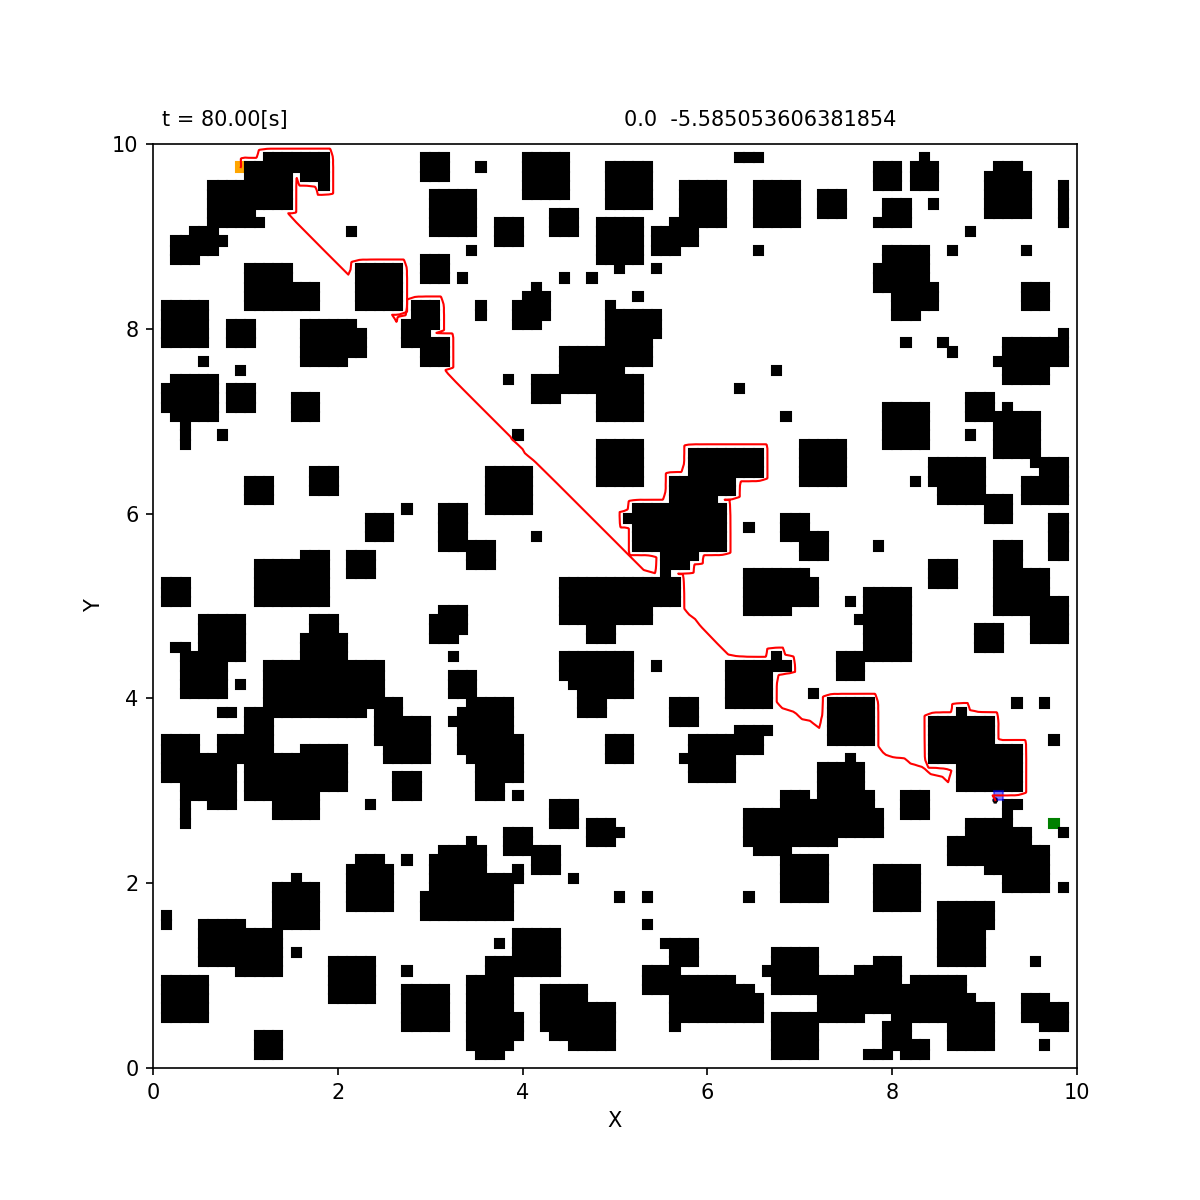

In [23]:
if __name__ == "__main__":
    time_span = 80
    time_interval = 0.1

    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([100, 100])

    map_data = "./csvmap/mr/map_30.csv"
    #map_data = "./csvmap/map2.csv"

    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, time_show="time", debug=False, is_dynamic=False)
    #world.resetStartAndGoal(np.array([30, 2]), np.array([78, 90]))
    world.resetStartAndGoal(np.array([9, 97]), np.array([97, 26]))
    #world.resetStartAndGoal()
    print(world.start_index, world.goal_index)
    
    #pp_algorithm = DstarLite(world, drawMetricMap_flag=True)
    #pp_algorithm = Astar(world)
    pp_algorithm = BUG(world)
    #world.append(PathFollower(world, pp_algorithm))
    world.append(BugFollower(world))
    world.draw(figsize=(8, 8))
    #world.ani.save('path_bug.', writer='ffmpeg', fps=100)    #アニメーション保存